In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')
# install prereqs
!pip install cellrank scanpy pot colour pykeops statot
# if we want monitoring 
# !pip install wandb
# import wandb
# wandb.init()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!apt-get install cuda=10.2.89-1
!pip install pykeops
import pykeops
# pykeops.clean_pykeops()          # just in case old build files are still present
# pykeops.test_numpy_bindings()    # perform the compilation

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  cuda-10-2 cuda-command-line-tools-10-2 cuda-compiler-10-2 cuda-cudart-10-2
  cuda-cudart-dev-10-2 cuda-cufft-10-2 cuda-cufft-dev-10-2 cuda-cuobjdump-10-2
  cuda-cupti-10-2 cuda-cupti-dev-10-2 cuda-curand-10-2 cuda-curand-dev-10-2
  cuda-cusolver-10-2 cuda-cusolver-dev-10-2 cuda-cusparse-10-2
  cuda-cusparse-dev-10-2 cuda-demo-suite-10-2 cuda-documentation-10-2
  cuda-driver-dev-10-2 cuda-gdb-10-2 cuda-libraries-10-2
  cuda-libraries-dev-10-2 cuda-license-10-2 cuda-memcheck-10-2
  cuda-misc-headers-10-2 cuda-npp-10-2 cuda-npp-dev-10-2 cuda-nsight-10-2
  cuda-nsight-compute-10-2 cuda-nsight-systems-10-2 cuda-nvcc-10-2
  cuda-nvdisasm-10-2 cuda-nvgraph-10-2 cuda-nvgraph-dev-10-2 cuda-nvjpeg-10-2
  cuda-nvjpeg-dev-10-2 cuda-nvml-dev-10-2 cuda-nvprof-10-2 cuda-nvprune-10-2
  cuda-nvrtc-10-2 cuda-nvrtc-dev-10-2 cuda-nvtx-10-2 cuda-nvvp-10-2
  

In [ ]:
import numpy as np
import pandas as pd
import scipy
import scanpy
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import ipywidgets as widgets
import anndata
import statot
import colour
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import normalize
import pykeops
from pykeops.numpy import LazyTensor, Vi, Vj

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# load full anndata 
adata = anndata.read_h5ad("/content/drive/MyDrive/adata_raw_SCT_0914_with_fates.h5ad")

In [ ]:
# adata = scanpy.pp.subsample(adata, fraction = 0.1, copy = True)
scanpy.pp.highly_variable_genes(adata, n_top_genes = 1500)
scanpy.pp.pca(adata, use_highly_variable = True)

In [ ]:
adata.obsm['X_umap'] = np.array([adata.obs.x, adata.obs.y]).T
adata.obs.simple_growth = adata.obs.growth

In [ ]:
adata.obsm["X_pca"].shape

(110427, 50)

In [ ]:
# Generate colors by lineage for visualization
lineage_colors = {"Putative Quiescent Center": "#9400d3", "Stem Cell Niche": 'tab:pink', "Columella": "#5ab953", 
                  "Lateral Root Cap": "#bfef45", "Atrichoblast": "#008080", "Trichoblast": "#21B6A8", 
                  "Cortex": "#82b6ff", "Endodermis": "#0000FF", "Pericycle": "#ff9900", 
                  "Phloem": "#e6194b", "Xylem": "#9a6324", "Procambium": "#ffe119"}

adata.obs['lineage_color'] = adata.obs['celltype.anno'].apply(lambda x: lineage_colors[x])

def create_legend_entry(lin):
    label = lin if lin != 'Putative Quiescent Center' else 'Quiescent Center'
    return Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=lineage_colors[lin], markersize=10)

lineage_handles = [create_legend_entry(lin) for lin in lineage_colors.keys()]

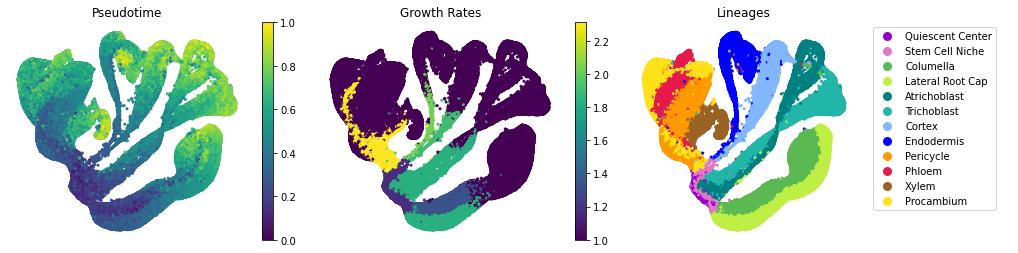

In [ ]:
# Plot pseudotime, growth rates, and lineages
fig = plt.figure(figsize = (18, 4))
gs = fig.add_gridspec(1, 13)

plt.subplot(gs[:,:4])
plt.axis('off')
plt.title('Pseudotime')
plt.scatter(adata.obsm['X_umap'][:,0], adata.obsm['X_umap'][:,1], s = 4, c = adata.obs['consensus.time'])
plt.colorbar()

plt.subplot(gs[:, 4:8])
plt.axis('off')
plt.title('Growth Rates')
plt.scatter(adata.obsm['X_umap'][:,0], adata.obsm['X_umap'][:,1], s = 4, c = adata.obs['growth'])
plt.colorbar()

plt.subplot(gs[:,8:11])
plt.axis('off')
plt.title('Lineages')
plt.scatter(adata.obsm['X_umap'][:,0], adata.obsm['X_umap'][:,1], s = 4, c = adata.obs['lineage_color'])

plt.subplot(gs[:,11:])
plt.axis('off')
plt.legend(handles=lineage_handles, loc='upper left')

plt.show()

In [ ]:
# Assign the 5% most differentited cells by pseudotime in each lineage as sinks
lineages = pd.unique(adata.obs['celltype.anno']) 
terminal_lineages = [lin for lin in lineages if lin not in ['Putative Quiescent Center', 'Stem Cell Niche']]
adata.obs['sink'] = False

for lin in terminal_lineages:
        sink_percentile = 0.95
        thresh = adata.obs.loc[adata.obs['celltype.anno'] == lin]['consensus.time'].quantile(sink_percentile)
        adata.obs.loc[adata.obs['celltype.anno'] == lin, 'sink'] = (adata.obs[adata.obs['celltype.anno'] == lin]['consensus.time'] >= thresh)

In [ ]:
terminal_lineages

['Atrichoblast',
 'Cortex',
 'Columella',
 'Lateral Root Cap',
 'Pericycle',
 'Xylem',
 'Endodermis',
 'Phloem',
 'Procambium',
 'Trichoblast']

In [ ]:
adata.obs['source'] = adata.obs['sink'].apply(lambda x: not x)

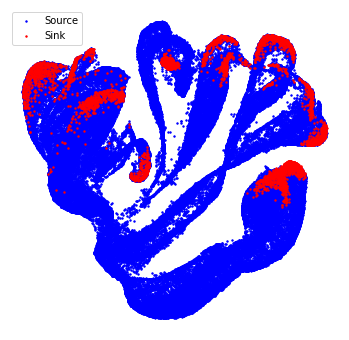

In [ ]:
# Plot sources and sinks on the umap
plt.figure(figsize=(6,6))
plt.scatter(adata.obs.x[adata.obs.source], adata.obs.y[adata.obs.source], color = 'blue', s = 8, marker='.', label='Source')
plt.scatter(adata.obs.x[adata.obs.sink], adata.obs.y[adata.obs.sink], color = 'red', s = 8, marker='.', label='Sink')
plt.legend()
plt.axis('off')
plt.show()

In [ ]:
# set up growth rates to supply
growth = adata.obs.growth.copy()
growth.loc[adata.obs.sink == True] = 0 # sinks have a growth rate of 0 (i.e. they are fully replaced)

In [ ]:
import statot.keops
statot.keops.set_dtype("float32")
from statot.keops import dtype

In [ ]:
X = adata.obsm["X_pca"].astype(dtype)
C, norm = statot.keops.form_cost(X, X, norm_factor = "mean", keops = True)
mu, nu = statot.statot(adata.obsm['X_pca'], method = "marginals", g = growth, dt = 0.25)

Compiling libKeOpsnumpy98e17998e7 in /root/.cache/pykeops-1.4.2-cpython-37:
       formula: Sum_Reduction((Sum(Square((Var(0,50,0) - Var(1,50,1)))) * Var(2,1,1)),0)
       aliases: Var(0,50,0); Var(1,50,1); Var(2,1,1); 
       dtype  : float32
... Done.


In [ ]:
import time

In [ ]:
# Entropic regularisation
eps = 0.025
K = (-C/eps).exp()
t0 = time.time()
u, v = statot.keops.sinkhorn(np.array(mu, dtype = dtype), 
                             np.array(nu, dtype = dtype), 
                             K, verbose = True, max_iter = 1250, err_check = 50,
                             tol = 1e-3)
t1 = time.time()
print("--- %s seconds ---" % (t1 - t0))
Q, R = statot.keops.get_QR_submat_ent(u, K, v, X, np.array(adata.obs.sink), eps, norm)
# def get_QR_reg(h):
#   C_reg, _ = statot.keops.form_cost(X, X, norm_factor = 1, keops = True)
#   z_C_reg = h*(C_reg @ np.ones(C_reg.shape[1], dtype = dtype))/float(C_reg.shape[1])
#   C_reg_norm = C_reg * Vi(1/(z_C_reg.reshape(-1, 1)))
#   K_reg = (-C_reg_norm).exp()
#   z_reg = K_reg @ np.ones(K_reg.shape[1], dtype = dtype)
#   K_q_reg = (-statot.keops.form_cost(X[~adata.obs.sink, :], X[~adata.obs.sink, :], norm_factor = 1)[0]/Vi(z_C_reg[~adata.obs.sink].reshape(-1, 1))).exp()
#   K_r_reg = np.exp(-statot.keops.form_cost(X[~adata.obs.sink, :], X[adata.obs.sink, :], norm_factor = 1, keops = False)[0]/z_C_reg[~adata.obs.sink].reshape(-1, 1))
#   Q_reg = K_q_reg * Vi(1/z_reg[~adata.obs.sink].reshape(-1, 1))
#   R_reg = K_r_reg * (1/z_reg[~adata.obs.sink].reshape(-1, 1))
#   return Q_reg, R_reg
# 
# Q_reg, R_reg = get_QR_reg(0.05)
# f = 0.025
# Q = (1-f)*Q_dir + f*Q_reg
# R = (1-f)*R_dir + f*R_reg

Compiling libKeOpsnumpyae5d856a09 in /root/.cache/pykeops-1.4.2-cpython-37:
       formula: Sum_Reduction((Exp((Minus((Sum(Square((Var(0,50,0) - Var(1,50,1)))) / Var(2,1,2))) / Var(3,1,2))) * Var(4,1,1)),0)
       aliases: Var(0,50,0); Var(1,50,1); Var(2,1,2); Var(3,1,2); Var(4,1,1); 
       dtype  : float32
... Done.
Compiling libKeOpsnumpy119475e471 in /root/.cache/pykeops-1.4.2-cpython-37:
       formula: Sum_Reduction((Exp((Minus((Sum(Square((Var(0,50,1) - Var(1,50,0)))) / Var(2,1,2))) / Var(3,1,2))) * Var(4,1,1)),0)
       aliases: Var(0,50,1); Var(1,50,0); Var(2,1,2); Var(3,1,2); Var(4,1,1); 
       dtype  : float32
... Done.
Iteration 0, Error = 8.648264
Iteration 50, Error = 0.237533
Iteration 100, Error = 0.201115
Iteration 150, Error = 0.092607
Iteration 200, Error = 0.063426
Iteration 250, Error = 0.045977
Iteration 300, Error = 0.043874
Iteration 350, Error = 0.043874
Iteration 400, Error = 0.043874
Iteration 450, Error = 0.043874
Iteration 500, Error = 0.043874
Iteration 5

In [ ]:
R_agg = np.array([R[:, adata.obs.loc[adata.obs.sink, "celltype.anno"] == l].sum(1) for l in terminal_lineages], dtype = dtype).T
t0 = time.time()
B = statot.keops.compute_fate_probs(Q, R_agg)
t1 = time.time()
print("--- %s seconds ---" % (t1 - t0))

Solving fate probabilities for lineage 0
Solving fate probabilities for lineage 1
Solving fate probabilities for lineage 2
Solving fate probabilities for lineage 3
Solving fate probabilities for lineage 4
Solving fate probabilities for lineage 5
Solving fate probabilities for lineage 6
Solving fate probabilities for lineage 7
Solving fate probabilities for lineage 8
Solving fate probabilities for lineage 9
--- 523.1054348945618 seconds ---


V100
Entropic: OT: 836s, fates: 539s

Quadratic: OT: 1315s, fates: 89s

In [ ]:
# Quadratic regularisation
eps = 2.5
t0 = time.time()
u, v = statot.keops.quad_ot_semismooth_newton(np.array(mu, dtype = dtype), 
                                              np.array(nu, dtype = dtype), 
                                              C, eps = eps, verbose = True, tol = 5e-3, cg_max_iter = 250, eta = 1e-5)
t1 = time.time()
print("--- %s seconds ---" % (t1 - t0))

Iteration  0 Error =  65261.31
Iteration  1 Error =  7122.68
Iteration  2 Error =  2190.046
Iteration  3 Error =  667.35876
Iteration  4 Error =  252.7904
Iteration  5 Error =  89.08614
Iteration  6 Error =  27.84957
Iteration  7 Error =  8.799612
Iteration  8 Error =  3.164464
Iteration  9 Error =  1.650667
Iteration  10 Error =  1.1132629
Iteration  11 Error =  0.25450218
Iteration  12 Error =  0.075366855
Iteration  13 Error =  0.025127769
Iteration  14 Error =  0.0056486647
Iteration  15 Error =  0.00091320276
--- 1451.8099522590637 seconds ---


In [ ]:
Q, R = statot.keops.get_QR_submat_quad(u, C, v, X, sink_idx = adata.obs.sink, eps = eps, cost_norm_factor = norm)

In [ ]:
Q @ np.ones(Q.shape[1], dtype = dtype) + R @ np.ones(R.shape[1], dtype = dtype)

Compiling libKeOpsnumpyd4ce4b5331 in /root/.cache/pykeops-1.4.2-cpython-37:
       formula: Sum_Reduction((((ReLU(((Var(0,1,1) + Var(1,1,0)) - (Sum(Square((Var(2,50,1) - Var(3,50,0)))) / Var(4,1,2)))) / Var(5,1,2)) / Var(6,1,0)) * Var(7,1,1)),0)
       aliases: Var(0,1,1); Var(1,1,0); Var(2,50,1); Var(3,50,0); Var(4,1,2); Var(5,1,2); Var(6,1,0); Var(7,1,1); 
       dtype  : float32
... Done.


array([0.9999999, 1.0000001, 1.0000004, ..., 0.9999999, 1.       ,
       1.0000001], dtype=float32)

In [ ]:
R_agg = np.array([R[:, adata.obs.loc[adata.obs.sink, "celltype.anno"] == l].sum(1) for l in terminal_lineages], dtype = dtype).T

In [ ]:
t0 = time.time()
B = statot.keops.compute_fate_probs(Q, R_agg)
t1 = time.time()
print("--- %s seconds ---" % (t1 - t0))

Solving fate probabilities for lineage 0
Solving fate probabilities for lineage 1
Solving fate probabilities for lineage 2
Solving fate probabilities for lineage 3
Solving fate probabilities for lineage 4
Solving fate probabilities for lineage 5
Solving fate probabilities for lineage 6
Solving fate probabilities for lineage 7
Solving fate probabilities for lineage 8
Solving fate probabilities for lineage 9
--- 88.96799540519714 seconds ---


In [ ]:
R_agg.shape

(105051, 10)

In [ ]:
# check sparsity
sigma = (Vi(u.reshape(-1, 1)) + Vj(v.reshape(-1, 1)) - C).relu().sign()
(sigma @ np.ones(sigma.shape[1], dtype = dtype)).sum()/(sigma.shape[0]*sigma.shape[1])

0.0016667441453875216

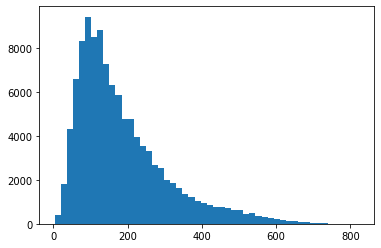

In [ ]:
plt.hist(sigma @ np.ones(sigma.shape[1], dtype = dtype), 50);

In [ ]:
B.sum(-1).min()

0.999806

In [ ]:
adata.uns["B_statot_quad"] = B
B_tmp = np.zeros((adata.shape[0], len(terminal_lineages)))
B_tmp[~adata.obs.sink, :] = adata.uns["B_statot_quad"]
L = np.stack([terminal_lineages, ]*adata.shape[0])
A = np.array([adata.obs["celltype.anno"] == L[:, i] for i in range(L.shape[1])], dtype = np.int).T
B_tmp[adata.obs.sink, :] = A[adata.obs.sink, :]

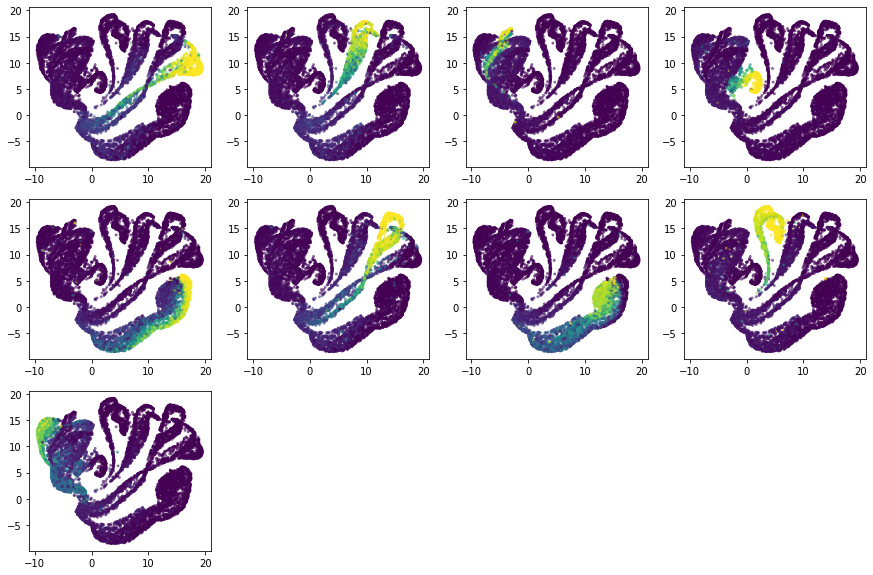

In [ ]:
plt.figure(figsize = (15, 10))
for i in range(0, 9):
  plt.subplot(3, 4, i+1)
  plt.scatter(adata.obsm["X_umap"][:, 0], adata.obsm["X_umap"][:, 1], c = B_tmp[:, i], s = 4, alpha = 0.5, vmin = 0, vmax = 1)
# cbar = plt.colorbar()
# cbar.set_alpha(1)
# cbar.draw_all()

In [ ]:
def get_P_as_csr(u, v, X, norm, sink_idx):
  T_rows = [scipy.sparse.csr_matrix(np.maximum(v[i] + u - statot.keops.form_cost(X[i:i+1, :], X, norm_factor = norm, keops = False)[0], 0)/eps) for i in range(v.shape[0])]
  for i in np.where(sink_idx)[0]:
    x = np.zeros(u.shape[0])
    x[i] = 1
    T_rows[i] = scipy.sparse.csr_matrix(x)
  T = scipy.sparse.vstack(T_rows) 
  from sklearn.preprocessing import normalize
  T = normalize(T, norm='l1', axis=1)
  return T

In [ ]:
P_csr = get_P_as_csr(u, v, X, norm, adata.obs.sink)

In [ ]:
def markov_fast(P, x, t):
  p = x
  for i in range(t):
    p = p @ P
  return p

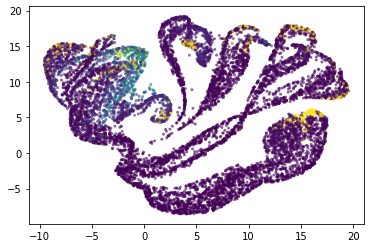

In [ ]:
pi0 = np.array(adata.obs.loc[:, "consensus.time"] < 0.25)
p = markov_fast(P_csr, pi0, 100)
plt.scatter(adata.obsm["X_umap"][:, 0], adata.obsm["X_umap"][:, 1], s = 4, alpha = 0.5, c = p, vmin = 0, vmax = np.quantile(p, 0.95))

In [ ]:
# np.save("drive/MyDrive/arabidopsis_fates_quad.npy", B_tmp)

In [ ]:
terminal_lineages

['Atrichoblast',
 'Cortex',
 'Columella',
 'Lateral Root Cap',
 'Pericycle',
 'Xylem',
 'Endodermis',
 'Phloem',
 'Procambium',
 'Trichoblast']